In [8]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tabulate import tabulate

# Sklearn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [9]:
# Implementation of a class to predict the S&P 500 Index
class IndexData():

  def __init__(self, dataset, sequence_length):
    self.sequence_length = sequence_length

    # Load and preprocess the data from the given link (to a GitHub repo file)
    self.market_data = pd.read_parquet(dataset)
    self.preprocess_data()

    # Set the divisor values from https://ycharts.com/indicators/sp_500_divisor#:~:text=S%26P%20500%20Divisor%20is%20at,0.23%25%20from%20one%20year%20ago
    # The divisor is used to calculate the S&P 500 Index based on the total
    # market cap for the given quarter and is in the millions
    self.divisors = {2013: {'Q1': 8934.61, 'Q2': 8908.33, 'Q3': 8908.77, 'Q4': 8896.86},
                     2014: {'Q1': 8924.03, 'Q2': 8919.22, 'Q3': 8878.54, 'Q4': 8882.35},
                     2015: {'Q1': 8861.60, 'Q2': 8851.25, 'Q3': 8830.99, 'Q4': 8810.57},
                     2016: {'Q1': 8757.39, 'Q2': 8718.72, 'Q3': 8667.94, 'Q4': 8643.59},
                     2017: {'Q1': 8606.26, 'Q2': 8581.63, 'Q3': 8567.30, 'Q4': 8565.26},
                     2018: {'Q1': 8535.74, 'Q2': 8518.41, 'Q3': 8474.31, 'Q4': 8434.96}}

    # Calculate the S&P 500 Index
    self.extract_index_data()

    # Standardize the Index data
    self.standardize()

    # Split the data into training and testing (we'll use the first ~85% of prices
    # as training and the remaining ~15% as testing)
    self.train, self.test = self.index[:1070], self.index[1070:]

    # Generate input and target sequences for the training and testing data
    self.x_train, self.y_train, self.x_test, self.y_test = self.generate_sequences()

  # Preprocess the given dataset
  def preprocess_data(self):
    # Drop all unnecessary columns
    # We will only need the date, closing price, and volume
    self.market_data.drop(columns=['open', 'high', 'low', 'Name'], inplace=True)
    column_names = self.market_data.columns

    # Remove all rows with empty or missing values
    self.market_data.dropna(inplace=True)

    # Drop any duplicate rows
    self.market_data.drop_duplicates(inplace=True)

    # Convert the date column to datetime format
    self.market_data['date'] = pd.to_datetime(self.market_data['date'], format='%Y-%m-%d')

  # Calculate the S&P 500 Index using the closing price for every day
  def extract_index_data(self):
    # Calculate the numerator to calculate the Index and group by the date
    self.market_data['index_numerator'] = self.market_data['close'] * self.market_data['volume']
    self.market_data.drop(columns=['close', 'volume'], inplace=True)
    self.index_data = self.market_data.groupby(['date']).sum().reset_index()

    # Apply the appropriate divisor based on the quarter
    def apply_divisor(row):
      # Q1 for January-March
      if row['date'].month in [1,2,3]:
        quarter = 'Q1'
      # Q2 for April-June
      elif row['date'].month in [4,5,6]:
        quarter = 'Q2'
      # Q3 for July-September
      elif row['date'].month in [7,8,9]:
        quarter = 'Q3'
      # Q4 for October-December
      else:
        quarter = 'Q4'
      return float(row['index_numerator']) / (self.divisors[row['date'].year][quarter] * 1e4)

    # Apply the divisor for every date's numerator
    self.index_data['index'] = self.index_data.apply(apply_divisor, axis=1)

    self.index = np.array(self.index_data['index'])

  # Standardize the index data
  def standardize(self):
    self.mean = np.mean(self.index)
    self.std = np.std(self.index)
    self.index = np.divide(np.subtract(self.index, self.mean), self.std)

  # Generate input and target sequences for the training and testing data
  def generate_sequences(self):
    x_train_sequences, y_train_sequences, x_test_sequences, y_test_sequences = [], [], [], []

    # Training sequences
    for i in range(len(self.train) - self.sequence_length-1):
      x_train_sequences.append(self.train[i : i+self.sequence_length])
      y_train_sequences.append(self.train[i+1 : i+self.sequence_length+1])

    # Testing sequences
    for i in range(len(self.test) - self.sequence_length - 1):
      x_test_sequences.append(self.test[i : i+self.sequence_length])
      y_test_sequences.append(self.test[i+1 : i+self.sequence_length+1])

    x_train_sequences = np.array(x_train_sequences)
    y_train_sequences = np.array(y_train_sequences)
    x_test_sequences = np.array(x_test_sequences)
    y_test_sequences = np.array(y_test_sequences)

    return x_train_sequences, y_train_sequences, x_test_sequences, y_test_sequences


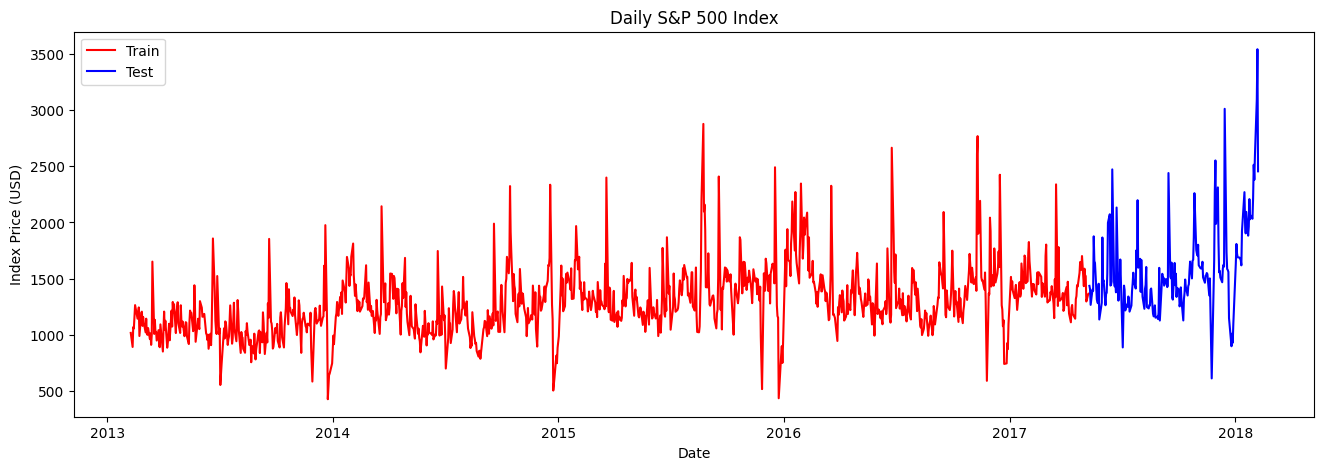

In [7]:
index_data_obj = IndexData('https://github.com/nikhilmanda9/ML-Stock-Market-Prediction/blob/main/all_stocks_5yr.parquet?raw=true', 5)

# Visualize the computed S&P 500 Index
fig = plt.subplots(figsize=(16, 5))
plt.plot(index_data_obj.index_data["date"][:1070], index_data_obj.index_data["index"][:1070], color='r')
plt.plot(index_data_obj.index_data["date"][1070:], index_data_obj.index_data["index"][1070:], color='b')
plt.title("Daily S&P 500 Index")
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Index Price (USD)')
plt.show()

In [47]:
# Implementation of the GRU model
class GRU:

    # Randomly initialize weight and bias matrices with the given input and
    # hidden layer sizes
    def __init__(self, x_train, y_train, learning_rate, num_epochs, hidden_size, sequence_length):
      self.x_train = x_train
      self.y_train = y_train
      self.learning_rate = learning_rate
      self.num_epochs = num_epochs
      self.hidden_size = hidden_size
      self.num_sequences, self.sequence_length = x_train.shape
      self.weights = {}

      # Weights and bias for Update gate
      self.weights['W_xz'] = np.random.randn(self.hidden_size, self.sequence_length)
      self.weights['W_hz'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.weights['b_z'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for Reset gate
      self.weights['W_xr'] = np.random.randn(self.hidden_size, self.sequence_length)
      self.weights['W_hr'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.weights['b_r'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for Candidate hidden state
      self.weights['W_xh'] = np.random.randn(self.hidden_size, self.sequence_length)
      self.weights['W_hh'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.weights['b_h'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for output
      self.weights['W_o'] = np.random.randn(self.sequence_length, self.hidden_size)
      self.weights['b_o'] = np.zeros((self.sequence_length, 1))

    # Train the model for the given number of epochs
    def fit(self):
      self.train_errs = []
      for epoch in range(self.num_epochs):
        print(f"Iteration {epoch}")
        # Forward pass
        preds = self.forward()

        # Compute Mean Sum of Squared Error
        train_err = np.sum(np.sum(np.square(np.subtract(self.y_train, preds)), axis=1)) / len(preds)
        self.train_errs.append(train_err)

        # Backprogapation
        self.backpropagate()

        # Update Weights, Biases, and State parameters
        for w in self.weights:
          self.weights[w] -= np.multiply(self.learning_rate, self.gradients['d' + w])

        print(train_err)

    # Forward propagation logic for the GRU model
    def forward(self):
      self.predictions = []
      self.outputs = []
      self.z_t, self.r_t, self.h_hat_t, self.h_t = [], [], [], []

      # Initialize the hidden state
      self.h_t.append(np.zeros((self.hidden_size, 1)))

      # i = 0
      # print(len(self.x_train))
      for x in self.x_train:
        # Update gate computation with sigmoid activation function
        #print(f"Iteration {i}")
        # i += 1
        z = self.sigmoid(np.dot(self.weights['W_xz'], x) + np.dot(self.weights['W_hz'], self.h_t[-1]) + self.weights['b_z'])
        self.z_t.append(z)

        # Reset gate computation with sigmoid activation function
        r = self.sigmoid(np.dot(self.weights['W_xr'], x) + np.dot(self.weights['W_hr'], self.h_t[-1]) + self.weights['b_r'])
        self.r_t.append(r)

        # Current hidden state computation with tanh activation function
        #h_hat = self.tanh(np.dot(self.weights['W_xh'], x) + np.dot(self.weights['W_hh'], self.h_t[-1] * r) + self.weights['b_h'])
        h_hat = self.tanh(np.dot(self.weights['W_xh'], x) + np.dot(self.weights['W_hh'], np.multiply(self.h_t[-1], r)) + self.weights['b_h'])
        self.h_hat_t.append(h_hat)

        # Update the hidden state
        h = np.multiply(z, self.h_t[-1]) + np.multiply((1 - z), h_hat)
        self.h_t.append(h)

        # Predict the output for the given input
        output = np.dot(self.weights['W_o'], h) + self.weights['b_o']
        pred = [np.mean(arr) for arr in output]

        self.predictions.append(pred)
        self.outputs.append(output)

      return np.array(self.predictions)

    # Sigmoid activation function
    def sigmoid(self, x):
      return (1 / (1 + np.exp(-x)))

    # Tanh activation function
    def tanh(self, x):
      return ((np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)))

    # Backpropagation logic for the GRU model
    def backpropagate(self):
      self.gradients = {}

      # Weights and bias for Update gate
      self.gradients['dW_xz'] = np.random.randn(self.hidden_size, self.sequence_length)
      self.gradients['dW_hz'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.gradients['db_z'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for Reset gate
      self.gradients['dW_xr'] = np.random.randn(self.hidden_size, self.sequence_length)
      self.gradients['dW_hr'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.gradients['db_r'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for Candidate hidden state
      self.gradients['dW_xh'] = np.random.randn(self.hidden_size, self.sequence_length)
      self.gradients['dW_hh'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.gradients['db_h'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for output
      self.gradients['dW_o'] = np.random.randn(self.sequence_length, self.hidden_size)
      self.gradients['db_o'] = np.zeros((self.sequence_length, 1))

      # Gradient for the hidden state
      dh_t = 0

      for i in range(len(self.x_train)-1, -1, -1):
        #print(f'Iteration {i}')
        # Output gradients
        do = self.outputs[i]
        self.gradients['dW_o'] += np.dot(do, np.transpose(self.h_t[i+1]))

        # Hidden state gradient
        dh_t += np.dot(np.transpose(self.weights['W_o']), do)

        # Update gate gradients
        dz_t1 = np.multiply((np.subtract(self.h_t[i], self.h_hat_t[i])), dh_t)
        dz_t2 = np.multiply(self.z_t[i], dh_t)
        dz_t = np.multiply(np.multiply(np.subtract(1, self.z_t[i]), self.z_t[i]), dz_t1)
        self.gradients['dW_xz'] += np.dot(dz_t, np.transpose(self.h_t[i]))
        self.gradients['dW_hz'] += np.dot(dz_t, np.transpose(self.x_train[i]))
        #self.gradients['db_z'] += dz_t
        self.gradients['db_z'] += np.sum(dz_t, axis=1, keepdims=True)

        # Candidate hidden state gradients
        #dh_hat_t = np.multiply(np.subtract(1, np.square(self.h_hat_t[i])), np.multiply(np.subtract(1, self.z_t[i]), dh_t))
        dh_hat_t = np.multiply(np.subtract(1, np.square(self.h_hat_t[i])),
                        np.multiply(np.subtract(1, self.z_t[i]), dh_t))
        self.gradients['dW_xh'] += np.dot(dh_hat_t, np.multiply(self.r_t[i], np.transpose(self.h_t[i])))
        self.gradients['dW_hh'] += np.dot(dh_hat_t, np.transpose(self.x_train[i]))
        #self.gradients['db_h'] += dh_hat_t
        self.gradients['db_h'] += np.sum(dh_hat_t, axis=1, keepdims=True)

        # Calulate reset gate gradients
        dr_t1 = np.dot(np.transpose(self.weights['W_xh']), dh_hat_t)
        dr_t2 = np.multiply(self.h_t[i], dr_t1)
        dr_t3 = np.multiply(np.multiply(np.subtract(1, self.r_t[i]), self.r_t[i]), dr_t2)
        #dr_t3 = np.multiply(np.multiply(np.subtract(1, self.r_t[i]), self.r_t[i]), dr_t2)
        dr_t3 = np.multiply(np.multiply(np.subtract(1, self.r_t[i]), self.r_t[i]), dr_t2)
        dr_t4 = np.multiply(self.r_t[i], dr_t1)
        # print('Shape of dr_t3:', dr_t3.shape)
        # print('Shape of np.transpose(self.h_t[i]):', np.transpose(self.h_t[i]).shape)
        self.gradients['dW_xr'] += np.dot(dr_t3, np.transpose(self.h_t[i]))
        #self.gradients['dW_xr'] += np.dot(dr_t3.T, self.h_t[i])
        self.gradients['dW_hr'] += np.dot(dr_t3, np.transpose(self.x_train[i]))
        #self.gradients['db_r'] += dr_t3
        self.gradients['db_r'] += np.sum(dr_t3, axis=1, keepdims=True)

        # Update the hidden state gradient
        dh = dz_t2 + dr_t4 + np.dot(np.transpose(self.weights['W_xz']), dz_t) + np.dot(np.transpose(self.weights['W_xr']), dr_t3)


In [48]:
gru = GRU(x_train=index_data_obj.x_train,
          y_train=index_data_obj.y_train,
          learning_rate=0.0001,
          num_epochs=1,
          hidden_size=5,
          sequence_length=5)
gru.fit()

Iteration 0


ValueError: ignored